In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from constants import DATETIME_FEATURE, TARGET, COUGH, FEVER, GENDER, HEADACHE, SHORTNESS_OF_BREATH, SORE_THROAT, AGE_60_AND_ABOVE, TEST_INDICATION
from plotting import plot_features, plot_timeline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

In [145]:
BINARY_FEATURES = [
    COUGH,
    FEVER,
    HEADACHE,
    SHORTNESS_OF_BREATH,
    SORE_THROAT,
]


CATEGORICAL_FEATURES = [
    AGE_60_AND_ABOVE,
    GENDER,
    TEST_INDICATION
]

ENCODED_TARGET = "encoded_corona_result"

In [146]:
corona_dataset = pd.read_csv("data/corona_tested_individuals_ver_006.english.csv")

/tmp/ipykernel_50635/499919021.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  corona_dataset = pd.read_csv("data/corona_tested_individuals_ver_006.english.csv")


In [147]:
corona_dataset.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,negative,NaN,male,Other
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,male,Other


Can't see NaNs - as they're strings of "None"

## Format of Feature values

Primarily contained binary features - with either 0 and 1, Yes / No, or positive / negative

Categorical features - test_indication, gender, target (should be binary, given the context of the task)

## Handling missing values

In [148]:
corona_dataset[DATETIME_FEATURE] = pd.to_datetime(corona_dataset[DATETIME_FEATURE])

In [149]:
# Replace strings of None with NaNs

corona_dataset = corona_dataset.replace(to_replace=['None'], value=np.nan)

In [150]:
corona_dataset.isna().sum()

test_date                   0
cough                     252
fever                     252
sore_throat                 1
shortness_of_breath         1
head_ache                   1
corona_result               0
age_60_and_above       127320
gender                  19563
test_indication             0
dtype: int64

## Feature relevancy: Statistical tests

In [153]:
# Chi-squared for independence - suitable for tests between categorical variables
# Cramer's V for assessing strength of association - significance tests are not sufficient. Look to also evaluate effect size of feature.

from scipy.stats import chi2_contingency


def cramers_v(chi2, n_total_observations, df):
    """Calculate Cramér's V for effect size"""
    return np.sqrt(chi2 / (n_total_observations * min(df - 1, df)))


def chi_squared_test(data, feature, significance_level: float = 0.05):
    contingency_table = pd.crosstab(data[feature], data[TARGET])    
    chi2, p_value, dof, _ = chi2_contingency(contingency_table)
    n_total_observations = contingency_table.sum().sum()

    effect_size = cramers_v(chi2, n_total_observations, min(contingency_table.shape))
    
    print("==========================================================================================================\n")
    print(f"Chi-Squared Test for feature '{feature}':")
    print(f"Chi2 statistic: {chi2}")
    print(f"P-value: {p_value}")
    print(f"Degrees of freedom: {dof}")
    
    print(f"\nSignificance level: {significance_level}")
    if p_value < significance_level:
        print("Conclusion: There is a significant association between the feature and the target.")
    else:
        print("Conclusion: There is no significant association between the feature and the target.")

    print(f"(Effect Size) Cramer's V: {effect_size*100:.3f}%")

    return chi2, effect_size


feature_stats = {}

# corona_dataset[AGE_60_AND_ABOVE] = corona_dataset[AGE_60_AND_ABOVE].fillna("Unknown")

for feature in BINARY_FEATURES + CATEGORICAL_FEATURES:
    chi_2, effect_size = chi_squared_test(corona_dataset, feature)
    feature_stats[feature] = {"chi_2": chi_2, "effect_size": effect_size}


Chi-Squared Test for feature 'cough':
Chi2 statistic: 10636.4177281666
P-value: 0.0
Degrees of freedom: 2

Significance level: 0.05
Conclusion: There is a significant association between the feature and the target.
(Effect Size) Cramer's V: 19.539%

Chi-Squared Test for feature 'fever':
Chi2 statistic: 19491.68624503912
P-value: 0.0
Degrees of freedom: 2

Significance level: 0.05
Conclusion: There is a significant association between the feature and the target.
(Effect Size) Cramer's V: 26.451%

Chi-Squared Test for feature 'head_ache':
Chi2 statistic: 37123.42032024283
P-value: 0.0
Degrees of freedom: 2

Significance level: 0.05
Conclusion: There is a significant association between the feature and the target.
(Effect Size) Cramer's V: 36.487%

Chi-Squared Test for feature 'shortness_of_breath':
Chi2 statistic: 14910.247721406447
P-value: 0.0
Degrees of freedom: 2

Significance level: 0.05
Conclusion: There is a significant association between the feature and the target.
(Effect Size

In [154]:
# Implications of introducing artifical category "Unknown" for NaNs - particularly when majority of age values are NaN
# Could potentially improve performance. Could also introduce bias. Needs careful consideration

corona_dataset_trial = corona_dataset.copy()
corona_dataset_trial[AGE_60_AND_ABOVE] = corona_dataset_trial[AGE_60_AND_ABOVE].fillna("Unknown")

for feature in BINARY_FEATURES + CATEGORICAL_FEATURES:
    chi_2, effect_size = chi_squared_test(corona_dataset_trial, feature)


Chi-Squared Test for feature 'cough':
Chi2 statistic: 10636.4177281666
P-value: 0.0
Degrees of freedom: 2

Significance level: 0.05
Conclusion: There is a significant association between the feature and the target.
(Effect Size) Cramer's V: 19.539%

Chi-Squared Test for feature 'fever':
Chi2 statistic: 19491.68624503912
P-value: 0.0
Degrees of freedom: 2

Significance level: 0.05
Conclusion: There is a significant association between the feature and the target.
(Effect Size) Cramer's V: 26.451%

Chi-Squared Test for feature 'head_ache':
Chi2 statistic: 37123.42032024283
P-value: 0.0
Degrees of freedom: 2

Significance level: 0.05
Conclusion: There is a significant association between the feature and the target.
(Effect Size) Cramer's V: 36.487%

Chi-Squared Test for feature 'shortness_of_breath':
Chi2 statistic: 14910.247721406447
P-value: 0.0
Degrees of freedom: 2

Significance level: 0.05
Conclusion: There is a significant association between the feature and the target.
(Effect Size

In [155]:
feature_stats

{'cough': {'chi_2': 10636.4177281666, 'effect_size': 0.19539356387880688},
 'fever': {'chi_2': 19491.68624503912, 'effect_size': 0.26450705958290377},
 'head_ache': {'chi_2': 37123.42032024283, 'effect_size': 0.36487239137773003},
 'shortness_of_breath': {'chi_2': 14910.247721406447,
  'effect_size': 0.2312381260751772},
 'sore_throat': {'chi_2': 21229.703141292743,
  'effect_size': 0.2759236792848946},
 'age_60_and_above': {'chi_2': 43.16288661421962,
  'effect_size': 0.016877526367861006},
 'gender': {'chi_2': 191.76491743224565, 'effect_size': 0.0271954270177685},
 'test_indication': {'chi_2': 90430.73068897007,
  'effect_size': 0.40267925384829634}}

## Feature relevancy: Visualisations

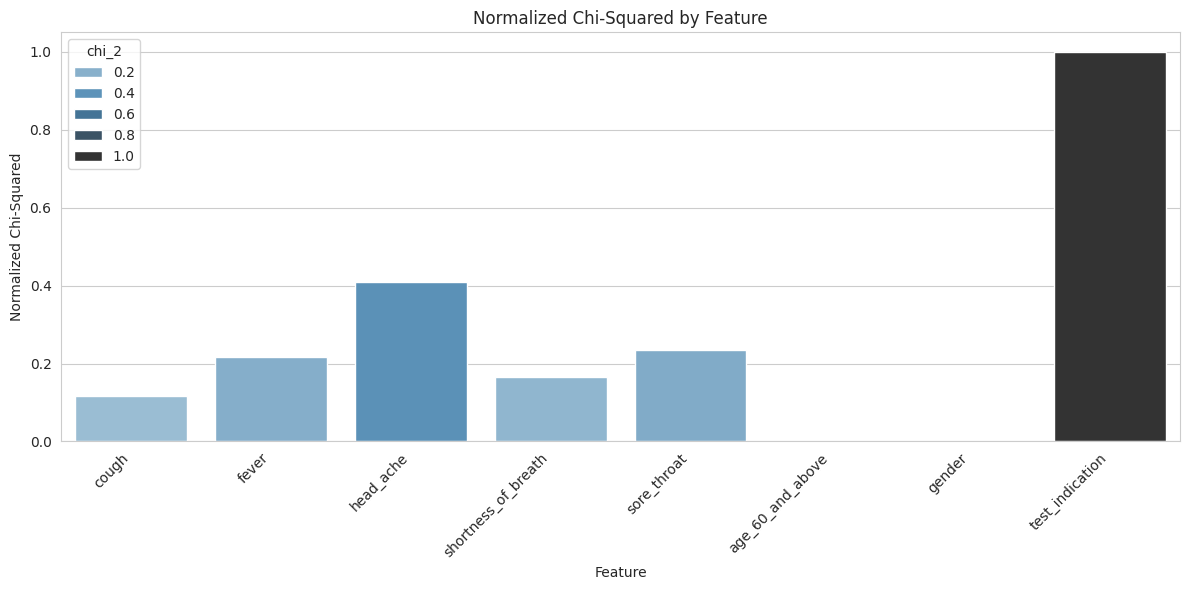

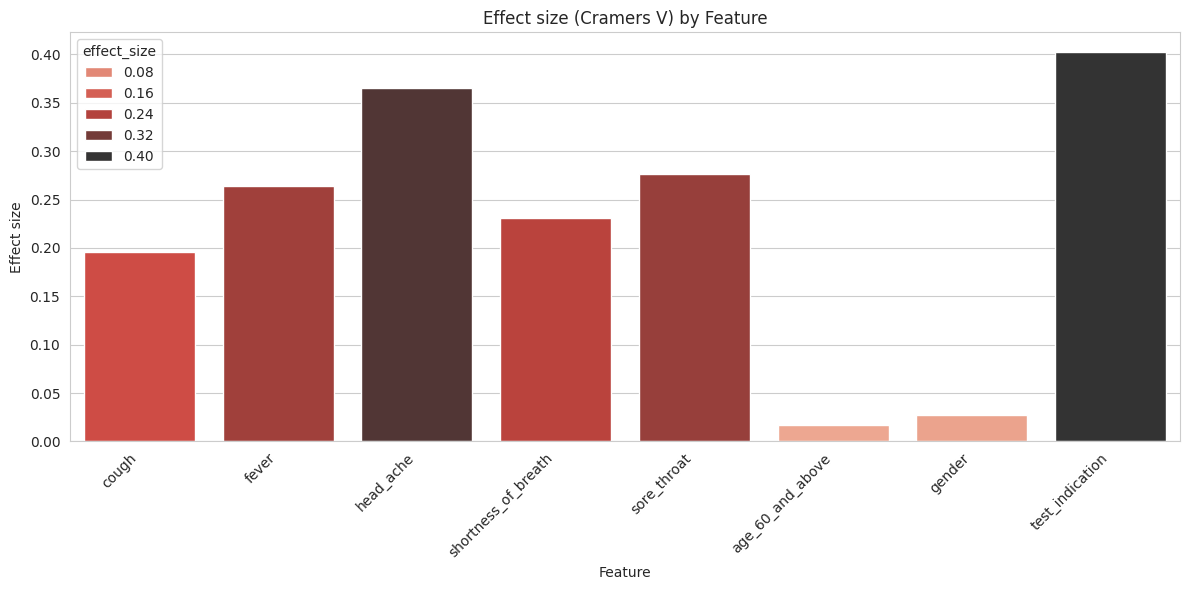

In [156]:
def plot_statistical_test_values(feature_stats: dict):
    stats_df = pd.DataFrame(feature_stats).T
    stats_df['chi_2'] = stats_df['chi_2'] / stats_df['chi_2'].max() # Normalised for visualisation purposes

    plt.figure(figsize=(12, 6))
    sns.barplot(x=stats_df.index, y='chi_2', data=stats_df, palette="Blues_d", hue="chi_2")
    plt.title('Normalized Chi-Squared by Feature')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Normalized Chi-Squared')
    plt.xlabel('Feature')
    plt.tight_layout()
    plt.show()

    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=stats_df.index, y='effect_size', data=stats_df, palette="Reds_d", hue="effect_size")
    plt.title("Effect size (Cramers V) by Feature")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Effect size")
    plt.xlabel('Feature')
    plt.tight_layout()
    plt.show()

plot_statistical_test_values(feature_stats)

In [157]:

def plot_symptom_relevancy_to_target(data):
    # Filter the dataset to exclude 'other' from the target variable for clearer analysis
    filtered_data = corona_dataset[corona_dataset[TARGET].isin(['negative', 'positive'])]
    filtered_data[symptom_columns] = filtered_data[BINARY_FEATURES].apply(pd.to_numeric, errors='coerce')
    symptom_means = filtered_data.groupby(TARGET)[symptom_columns].mean()
    
    symptom_means.T.plot(kind='bar', figsize=(10, 6))
    plt.title('Mean Symptom Reporting by COVID-19 Test Result')
    plt.ylabel('Mean Reporting Rate')
    plt.xlabel('Symptoms')
    plt.xticks(rotation=0)
    plt.legend(title='COVID-19 Test Result')
    plt.show()


def plot_gender_relevancy_to_target(data):
    data_with_nans = data.copy()
    data_with_nans[GENDER] = data_with_nans[GENDER].fillna("Unknown")
    
    plt.figure(figsize=(8, 6))
    sns.countplot(x=GENDER, hue=TARGET, data=data_with_nans)
    plt.title('COVID-19 Test Results by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.legend(title='COVID-19 Result')
    plt.show()


def plot_test_indication_relevancy_to_target(data):
    data_with_nans = data.copy()
    data_with_nans[TEST_INDICATION] = data_with_nans[TEST_INDICATION].fillna("Unknown")
    
    plt.figure(figsize=(10, 7))
    sns.countplot(x=TEST_INDICATION, hue=TARGET, data=data_with_nans, order=data_with_nans[TEST_INDICATION].value_counts().index)
    plt.title('COVID-19 Test Results by Test Indication')
    plt.xlabel('Test Indication')
    plt.ylabel('Count')
    plt.legend(title='COVID-19 Result')
    plt.show()


def plot_age_relevancy_to_target(data):
    data_with_nans = data.copy()
    data_with_nans[AGE_60_AND_ABOVE] = data_with_nans[AGE_60_AND_ABOVE].fillna("Unknown")
    
    plt.figure(figsize=(8, 6))
    sns.countplot(x=AGE_60_AND_ABOVE, hue=TARGET, data=data_with_nans)
    plt.title('COVID-19 Test Results by Age 60 and Above')
    plt.xlabel('Age 60 and Above')
    plt.ylabel('Count')
    plt.legend(title='COVID-19 Result')
    plt.show()


def plot_feature_relevancy_to_target(data):
    plot_symptom_relevancy_to_target(data)
    plot_gender_relevancy_to_target(data)
    plot_test_indication_relevancy_to_target(data)
    plot_age_relevancy_to_target(data)

/tmp/ipykernel_50635/3710936351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[symptom_columns] = filtered_data[BINARY_FEATURES].apply(pd.to_numeric, errors='coerce')


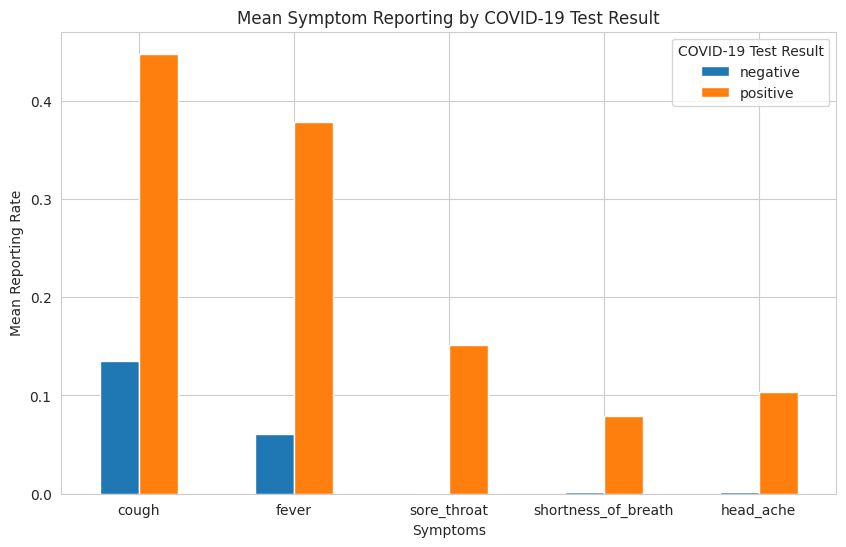

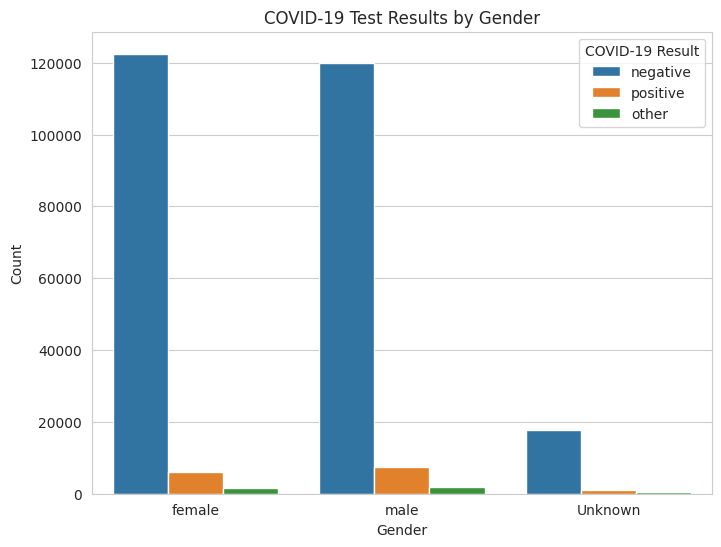

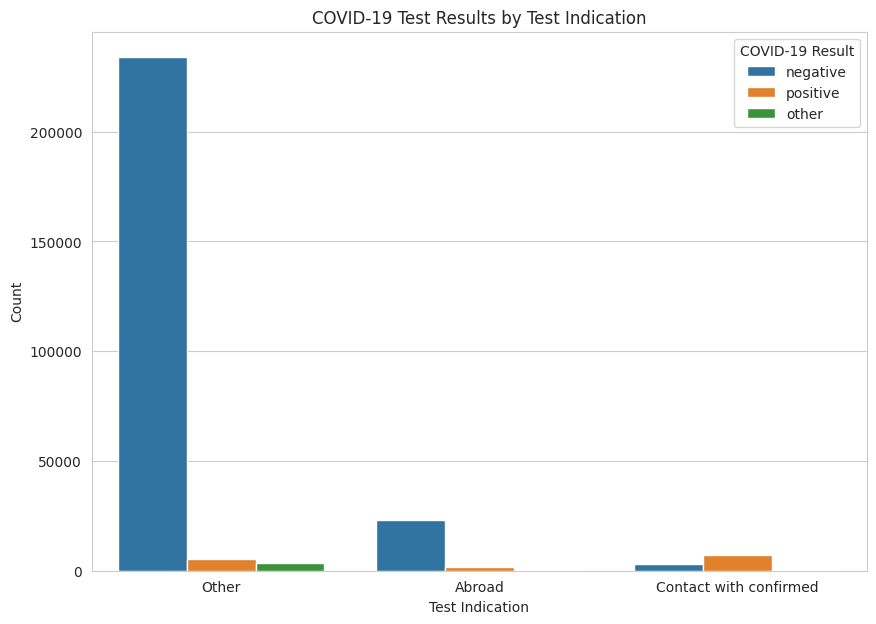

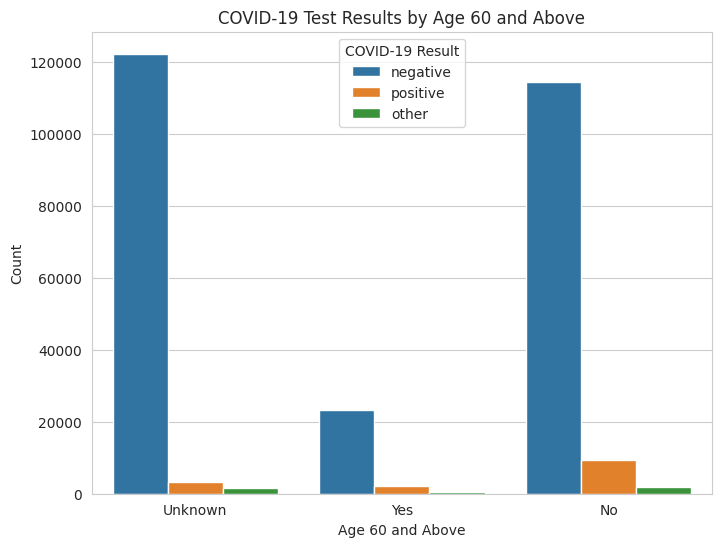

In [158]:
plot_feature_relevancy_to_target(corona_dataset)

# Key Observations

## Frequency plots

### Gender
- Gender plot reinforces the chi-squared findings of very low relevance to the target, as found by the chi-squared tests. Supporting our decision to drop it.

### Test Indication
- Test Indication plot - frequency of results across different test indicators.
    - -> Distribution is very different across these categories.
      - -> Contact with confirmed has greater proportion of positive diagnoses compared to the other categories.
      - Suggests that test_indication could be a strong predictor for the target variable - as it seems to have a significant relationship with the likelihood of a positive test result.
     
- --> We can look to engineer a "confirmed_contact" binary feature, from the test_indication feature.
  - Combine "Abroad" and "Other" into "Other"
  - Might capture the effect more directly; effect size 
  - Might improve model performance by highlighting a significant risk factor
  - LOOK OUT for overfitting - as it might capture noise with the signal.
 

### Age

- Large majority of cases where age is not reported.
    - Among the known age groups, cohorts below 60 years have been tested far more frequently than those over 60.
  - While fewer tests were conducted in this group subset - the risk of infection might still be significant; difficult to interpret without additional context and data.

- Proportion of anomalous diagnoses ("other") is not that large in comparison to Positive / Negative

- Relatively small number of positive results in both age categories could indicate lower
- POTENTIALLY - we could treat the missing age as informative. However, statistical tests (chi_squared) indicate very low relevance, and the plot indicates a different pattern happening here (sampling bias: majority of sample is under 60)


### "Other" in target
- "Other" value in the Target seems negligible, supporting our decision to remove it and focus on positive / negative in the target.

## Potential Biases and Limitations

1. Self-selection bias --> The individuals being tested might have symptoms or have been in contact with confirmed cases - which may hinder generalisability
2. Reporting bias --> Symptoms like cough or fever might more likely be reported - if they're severe or if the individual is already aware of potential exposure to COVID

## Sources of Uncertainty

1. Accuracy of self-reported symptoms --> Reliability of symptom reporting may vary
2. Test accuracy --> False positives / negatives in the target "corona_result" may introduce noise
3. Generalisability --> Dataset's applicability to broader populations outside the testing cohort (e.g., regional) is uncertain.
4. Missing data --> Handling the None values observed will need careful consideration 

## Assessing Class Imbalances

- Most of the reported symptoms are negative - indicating a sample majority did not report these symptoms
    -> Could be due to some form of bias - wherein individuals are being tested for reasons other than these symptoms.
        --> For example, "mandatory testing"

- This indicates a significant class imbalance - with majority of tests reporting negative.
- This imbalance presents a challenge in model training and evaluation - where the model potentially becomes biased to predict the negative class more.
    - Which generally means poorer performance for minority classes

In [171]:
target_distribution = corona_dataset['corona_result'].value_counts(normalize=True)
positive = target_distribution["positive"]
negative = target_distribution["negative"]
other = target_distribution["other"]

print(f"Distribution of COVID diagnoses: \nPositive: {positive*100:.3f}%\tNegative: {negative*100:.3f}%\tOther: {other*100:.3f}%")

Distribution of COVID diagnoses: 
Positive: 5.282%	Negative: 93.322%	Other: 1.396%


## Dealing with class imbalances

- Resampling --> SMOTE to oversample minority class or an alternative with undersampling - to balance the dataset
- Weighted loss functions --> Perhaps we could assign higher weights to the minority class in the loss function to penalise misclassifications of the positive class more than those of the negative
- Evaluation metrics --> Look into Precision-Recall curve, F1 score, alongside Area under the receiver operating characteristic to assess performance.
      --> These metrics are more informative (than accuracy) in imbalanced scenarios.

In [120]:
# Basic statistics of the feature values
feature_statistics = corona_dataset.describe(include='all')
feature_statistics

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
count,278848,278596.000000,278596.000000,278847.000000,278847.000000,278847.000000,278848,278848,259285,278848
unique,51,NaN,NaN,NaN,NaN,NaN,3,3,2,3
top,2020-04-20,NaN,NaN,NaN,NaN,NaN,negative,Unknown,female,Other
freq,10921,NaN,NaN,NaN,NaN,NaN,260227,127320,130158,242741
mean,NaN,0.151574,0.078077,0.006907,0.005655,0.008657,NaN,NaN,NaN,NaN
std,NaN,0.358608,0.268294,0.082821,0.074990,0.092640,NaN,NaN,NaN,NaN
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN


In [173]:
corona_dataset = corona_dataset[corona_dataset[TARGET] != 'other']

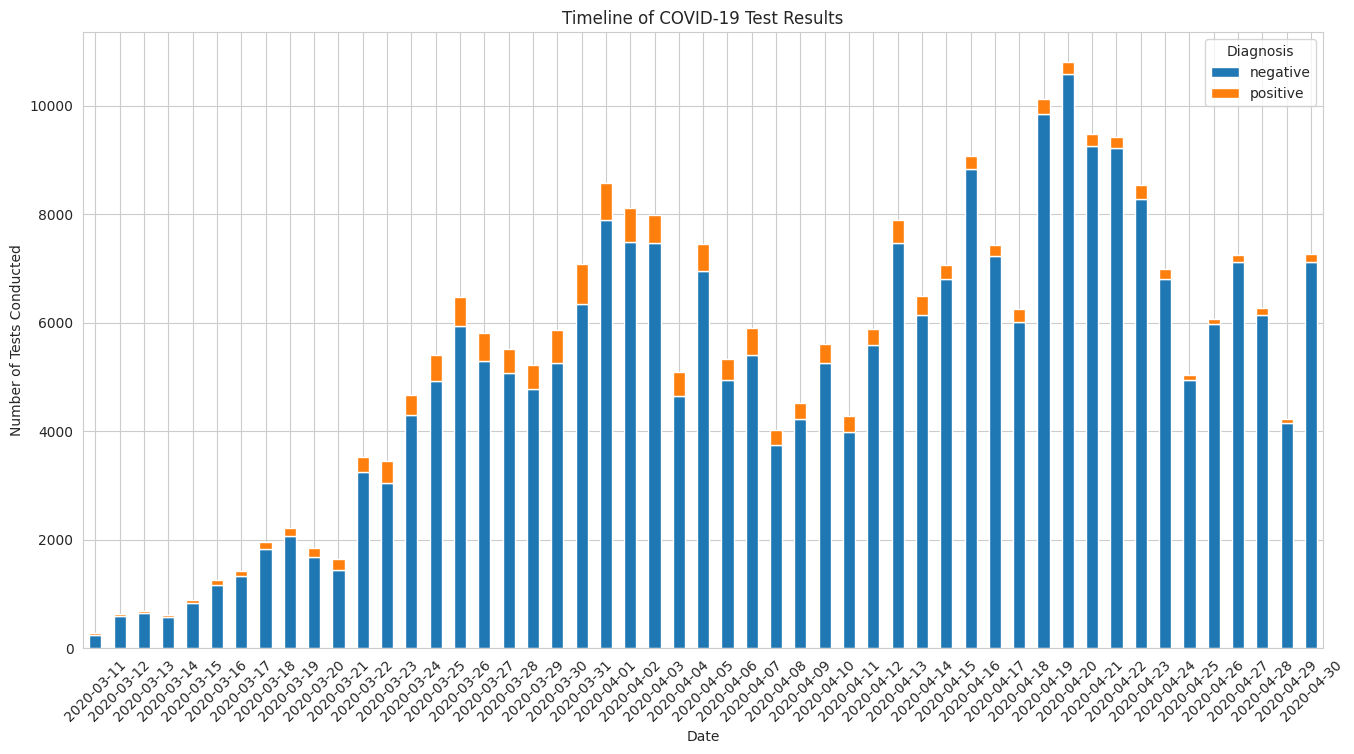

In [174]:
plot_timeline(corona_dataset, resample_parameter="D")

## Extract data into csv

In [175]:
LabelEncoder().fit_transform(corona_dataset[TARGET])

encoder = LabelEncoder()
encoded_target = encoder.fit_transform(corona_dataset[TARGET])
corona_dataset[ENCODED_TARGET] = encoded_target
corona_dataset = corona_dataset.drop(columns=[TARGET])

In [180]:
corona_dataset[AGE_60_AND_ABOVE] = corona_dataset[AGE_60_AND_ABOVE].fillna("Unknown")
corona_dataset[GENDER] = corona_dataset[GENDER].fillna("Unknown")

In [181]:
corona_dataset.isna().sum()

test_date                  0
cough                    252
fever                    252
sore_throat                1
shortness_of_breath        1
head_ache                  1
age_60_and_above           0
gender                     0
test_indication            0
encoded_corona_result      0
dtype: int64

In [182]:
corona_dataset = corona_dataset.dropna()

In [183]:
corona_dataset.isna().sum()

test_date                0
cough                    0
fever                    0
sore_throat              0
shortness_of_breath      0
head_ache                0
age_60_and_above         0
gender                   0
test_indication          0
encoded_corona_result    0
dtype: int64

In [184]:
corona_dataset.to_csv("data/corona_dataset_trial.csv", index=False)

In [185]:
pd.read_csv("data/corona_dataset_trial.csv")

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,test_indication,encoded_corona_result
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,Unknown,female,Other,0
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,Unknown,female,Other,0
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,Unknown,male,Other,0
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,Unknown,female,Other,0
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,Unknown,male,Other,0
...,...,...,...,...,...,...,...,...,...,...
274697,2020-03-11,0.0,0.0,0.0,0.0,0.0,Unknown,Unknown,Other,0
274698,2020-03-11,0.0,0.0,0.0,0.0,0.0,Unknown,Unknown,Other,0
274699,2020-03-11,0.0,0.0,0.0,0.0,0.0,Unknown,Unknown,Other,0
274700,2020-03-11,0.0,0.0,0.0,0.0,0.0,Unknown,Unknown,Contact with confirmed,1
